In [1]:
import sys
sys.path.append('..')
from common.np import *
from common.layers import Embedding, SigmoidWithLoss
import collections

## Embedding

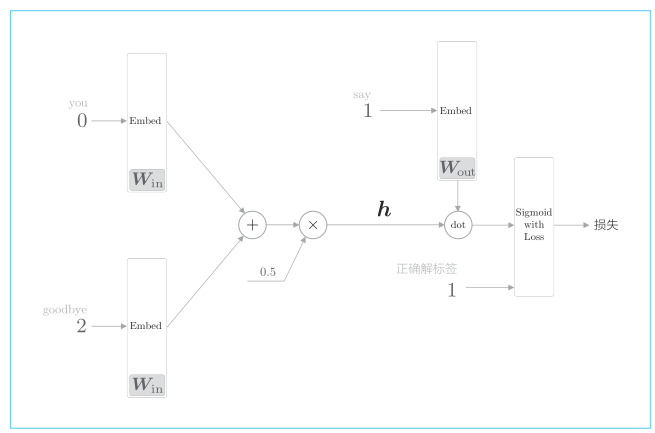

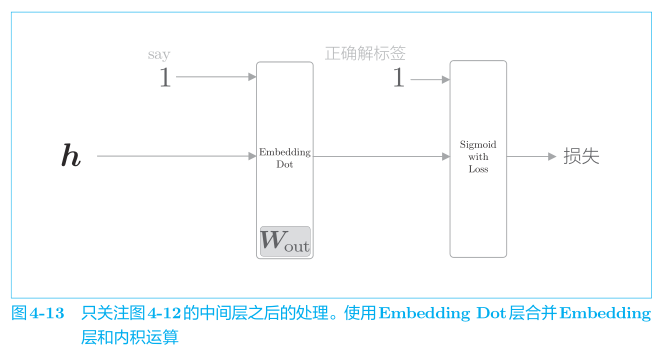

In [2]:
class EmbeddingDot:
    """
    二分类的CBOW模型中间层以后的计算层，将Embedding和dot层合并
    """
    def __init__(self, W):
        """
        embed: 保存embedding层
        cache: 保存正向传播时的计算结果
        params: 保存参数
        grads: 保存梯度
        """
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
    
    def forward(self, h, idx):
        """
        h: 中间层的神经元
        idx: 单词ID 的numpy数组。（mini-batch）
        """
        target_W = self.embed.forward(idx)
        out = np.sum(target_W*h, axis=1)
        
        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1) # 从一维向量扩展成二维向量，且是列向量？
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

forward计算过程示例，batch-size=3, hidden_size = 3

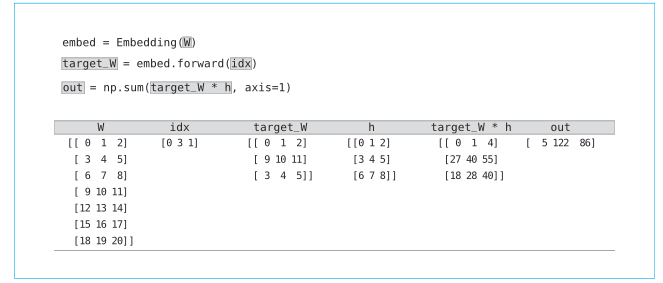

idx是数组，这样后面 NegativeSamplingLoss中forward的时候，正例可以一批的数据一起计算，反例也可以按照索引一批的数据一起计算。

但是，dout * h怎么理解呢？

## UnigramSampler

unigram 是“1 个（连 续）单 词”的 意 思。同 样 地，bigram 是“2个 连 续 单 词”的 意 思，trigram 是“3 个 连 续 单 词”的 意 思。这 里使 用UnigramSampler这 个 名 字，是 因 为 我 们 以 1 个 单 词 为 对 象 创建 概 率 分 布。如 果 是 bigram，则 以 (‘you’, ‘say’)、(‘you’, ‘goodbye’)……这样的 2 个单词的组合为对象创建概率分布。

In [4]:
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        """"
        corpus: 单词ID列表
        power: 对概率分布取的次方值
        sample_size: 负例的采样个数
        """
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None   # 单词对应的概率
        
        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1
        
        vocab_size = len(counts)
        self.vocab_size = vocab_size  # 设置单词个数（不重复）
        
        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]  # 单词出现次数
            
        self.word_p = np.power(self.word_p, power)  # 初始概率进行0.75次方
        self.word_p /= np.sum(self.word_p) 
    
    def get_negative_sample(self, target):
        """"
        target :指定的正例数组
        """
        batch_size = target.shape[0]
        
        if not GPU:  # 将目标词排除在外
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)
            for i in range(batch_size):
                p = self.word_p.copy() # 防止修改导致后面循环出错
                target_idx = target[i]
                p[target_idx] = 0  # 将正例排除在外
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
                
        else:
             # 在用GPU(cupy）计算时，优先速度
            # 有时目标词存在于负例中
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)
        return negative_sample

负采样计算概率的时候需要将 正例排除在外，重新计算

## NegativeSamplingLoss

In [5]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        """
        W :输出层的权重
        corpus ：语料库的单词ID列表
        power 概率分布的次方值
        sample_size :负采样的个数
        """
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)] # 为sample_size个负采样和一个正例样例创建Sigmoid层
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)] # 同理，创建EmbeddingDot层
        
        self.params, self.grads = [], []
        for layer in self.embed_dot_layer:
            self.params += layer.params
            self.grads += layer.grads
        # SigmoidWithLoss层没有params和grads，因此不用保存
        
    def forward(self, h, target):
        """
        h :中间层的神经元h
        target : 正例目标target
        """
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)
        
        # 正例的正向传播 认为索引为0
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)
        
        # 反例的正向传播
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)
            
        return loss
    
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
        return dh

**正向传播**：
> 首先使用self.sampler采样负例，并设为negative_sample。然后，分别对正例和负例的数据进行正向传播，求损失的和。具体而言，通过 Embedding Dot 层的forward输出得分，再将这个得分和标签一起输入 Sigmoid with Loss 层来计算损失。并且进行的是一个mini-batch的计算

**反向传播**
> 反向传播的实现非常简单，只需要以与正向传播相反的顺序调用各层的backward()函数即可。在正向传播时，中间层的神经元被复制了多份，这相当于  Repeat 节点。因此，在反向传播时，需要将多份梯度累加起来。